# Part 1: Get key packages and data

In [3]:
#-- import key packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from sklearn import datasets
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

#-- get data

iris = datasets.load_iris()

features = iris.feature_names
target_names = iris.target_names

dict_TargetNames = {
    0: target_names[0],
    1: target_names[1],
    2: target_names[2]
}

df = pd.DataFrame(data=iris.data)
df.columns = features

df['iris_category'] = iris.target
df['iris_category_name'] = df['iris_category'].apply(lambda x: dict_TargetNames[x])

print('### View head of data')
print(df.head())
print('')



### View head of data
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   iris_category iris_category_name  
0              0             setosa  
1              0             setosa  
2              0             setosa  
3              0             setosa  
4              0             setosa  



# Part 2: Brief exploration of data

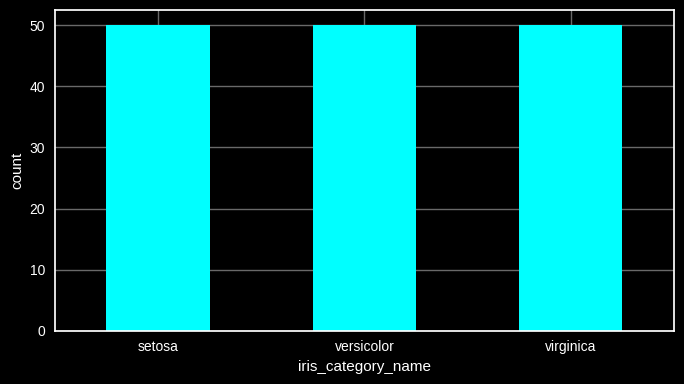

In [15]:
#-- exploring: view counts of each category

from matplotlib import gridspec
plt.style.use('dark_background')
plt.style.context("dark_background")

num_colors = 4
color = plt.cm.cool(np.linspace(0, 1, num_colors))
cyc = plt.cycler('color', color)
plt.rc('axes', prop_cycle=cyc)

fig = plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1])
ax1 = plt.subplot(gs[0])

plot_title = 'Counts of Iris Categories'

df['iris_category_name'].value_counts().plot(kind='bar', rot=0, ylabel='count', ax=ax1)

ax1.grid(c='dimgray')

plt.tight_layout()


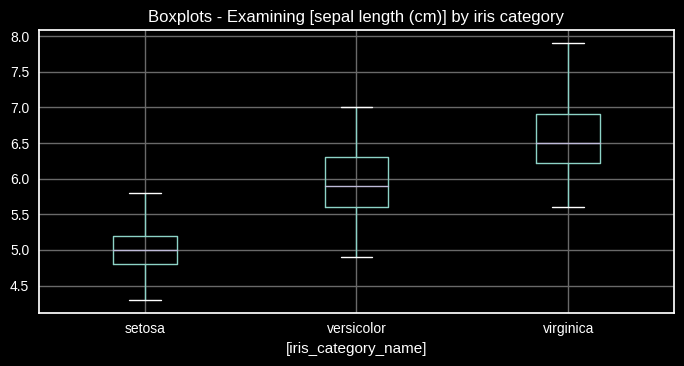

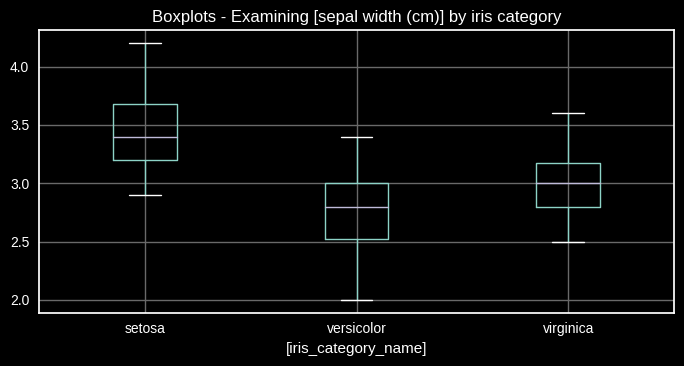

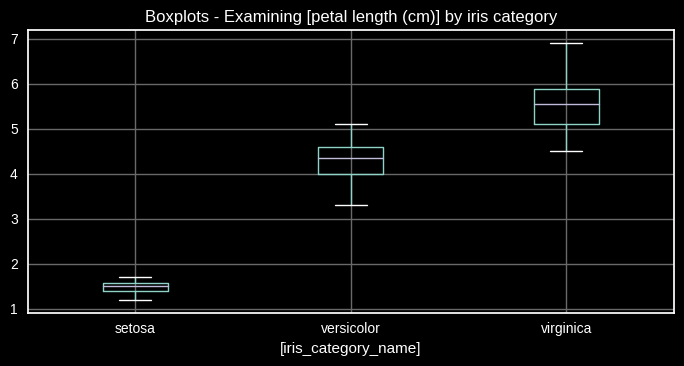

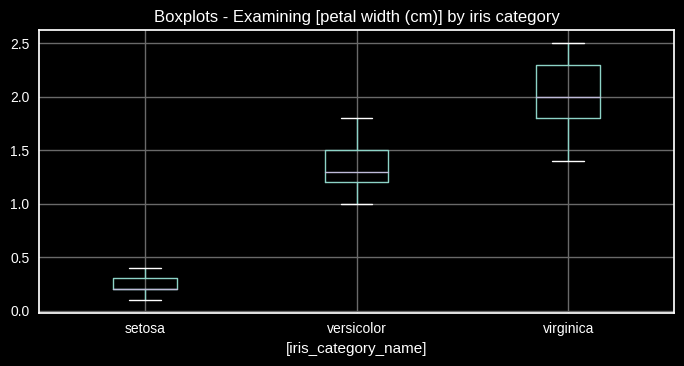

In [16]:
#-- exploring: view distribution of each feature by category of y (boxplots)

for x in features:

  from matplotlib import gridspec
  plt.style.use('dark_background')
  plt.style.context("dark_background")

  fig = plt.figure(figsize=(7, 4))
  gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1])
  ax1 = plt.subplot(gs[0])

  plot_title = f'Boxplots - Examining [{x}] by iris category'

  df[[x,'iris_category_name']].boxplot(by='iris_category_name', ax=ax1, showfliers=False, capprops={'color': 'white'})
  ax1.set_title(plot_title)
  ax1.get_figure().suptitle("")

  ax1.grid(c='dimgray')

  plt.tight_layout()


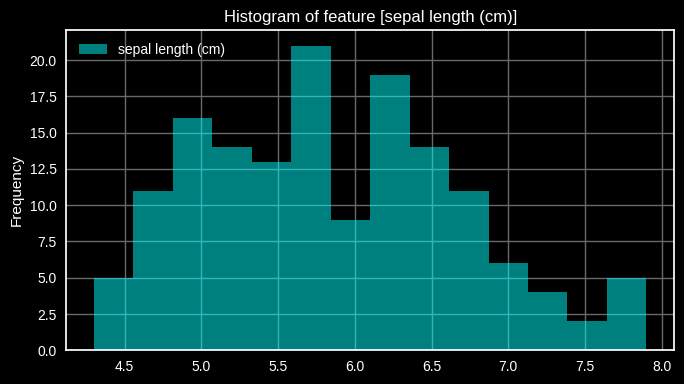

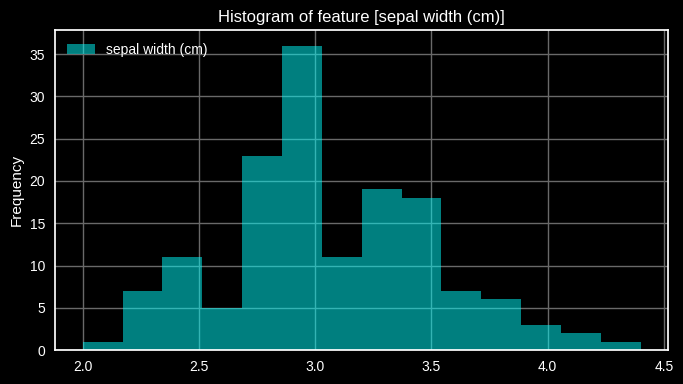

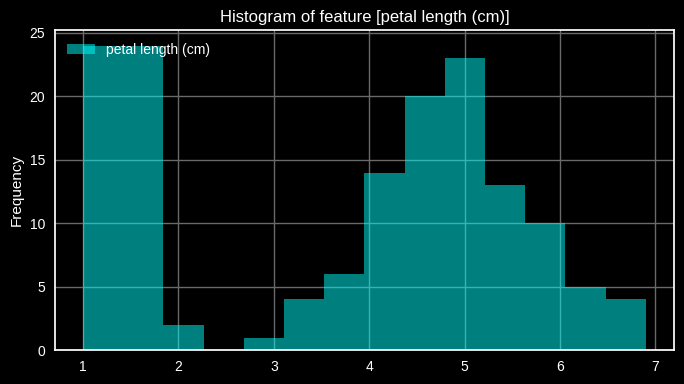

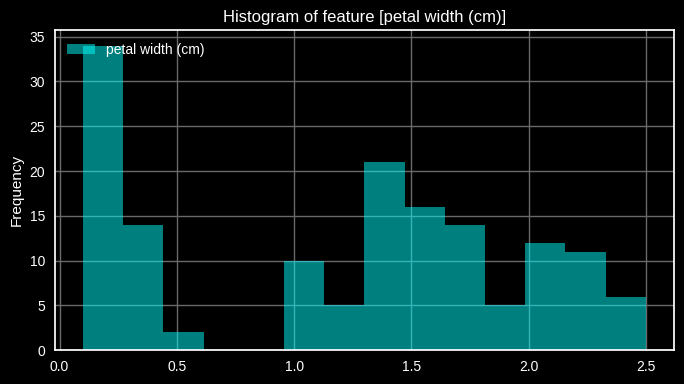

In [17]:
#-- exploring: view histogram of each potential feature

for x in features:

  from matplotlib import gridspec
  plt.style.use('dark_background')
  plt.style.context("dark_background")

  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(7, 4))
  gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1])
  ax1 = plt.subplot(gs[0])

  plot_title = f'Histogram of feature [{x}]'

  df[[x]].plot.hist(ax=ax1, bins=14, alpha=0.5, title=plot_title)

  ax1.grid(c='dimgray')
  ax1.yaxis.set_label_position("left")
  plt.legend(loc='upper left')

  plt.tight_layout()


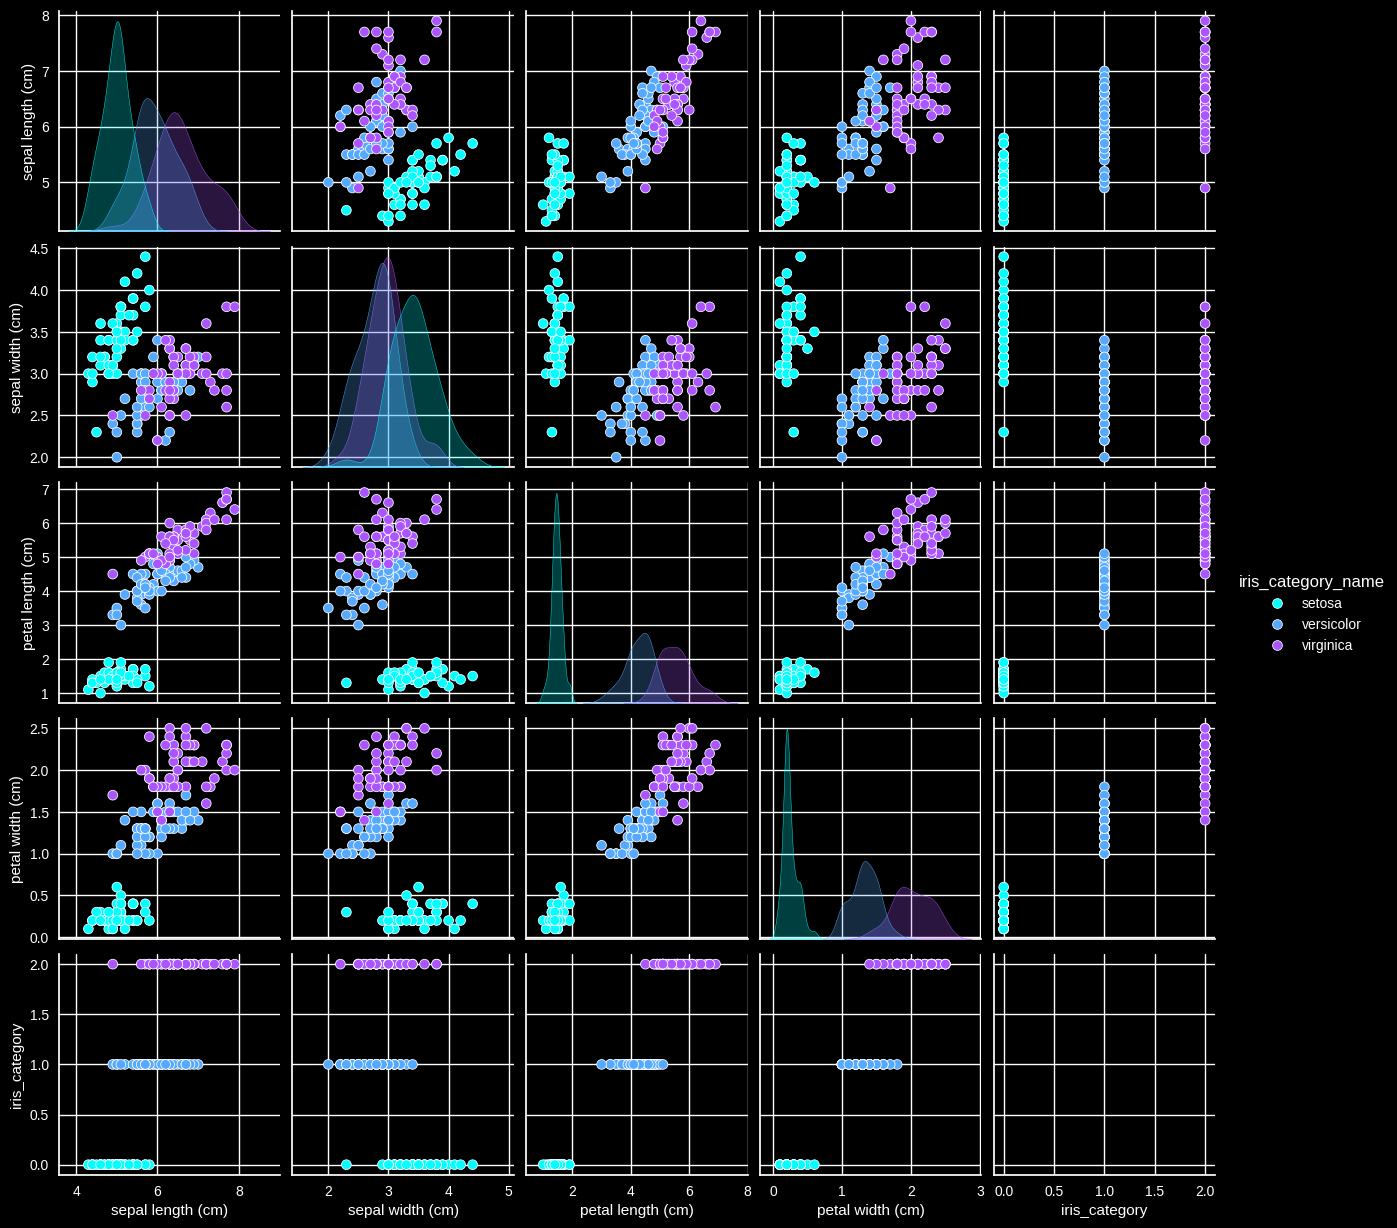

In [13]:
#-- exploring: view pair plot

sns.pairplot(df, hue='iris_category_name')

# Part 4: Try a model with n_clusters = 3

In [5]:
#-- try a model

X = df[features]
y = df['iris_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

model = KMeans(n_clusters=3, random_state=42)

model.fit(X_train)

y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)

print(y_preds_test[:5])

model_inertia = model.inertia_
model_silhouette_score = silhouette_score(X_test, y_preds_test)
model_class_report = classification_report(y_test, y_preds_test)
model_f1_WeightedAvg = f1_score(y_test, y_preds_test, average='weighted')

print(f'# model_inertia: {model_inertia:.3f}')
print(f'# model_silhouette_score: {model_silhouette_score:.3f}')
print(f'# model_f1_WeightedAvg: {model_f1_WeightedAvg:.3f}')
print('# model classification report:')
print(model_class_report)




[0 0 0 1 1]
# model_inertia: 53.223
# model_silhouette_score: 0.527
# model_f1_WeightedAvg: 0.912
# model classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.76      1.00      0.87        13
           2       1.00      0.79      0.88        19

    accuracy                           0.91        45
   macro avg       0.92      0.93      0.92        45
weighted avg       0.93      0.91      0.91        45



# Part 5: See how model performance varies as n_clusters changes

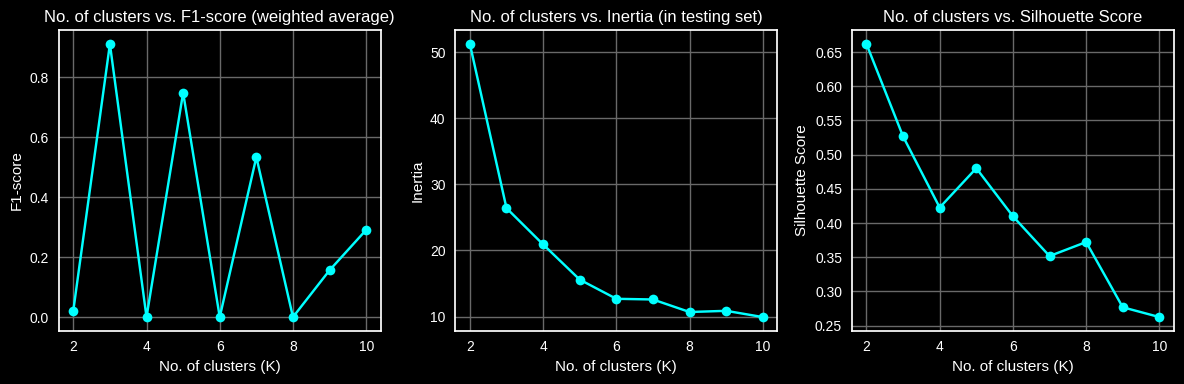

In [14]:
#-- see how the f1 score and the inertia change as the number of clusters changes

list_n_clusters = range(2,11)
f1scores_TestingSet = []
silhouette_scores_TestingSet = []
inertias_TestingSet = []


for n_clusters in list_n_clusters:

  model = KMeans(n_clusters, random_state=42).fit(X_train)

  y_preds_train = model.predict(X_train)
  y_preds_test = model.predict(X_test)

  f1_WeightedAvg_i = f1_score(y_test, y_preds_test, average='weighted')
  silhouette_score_i = silhouette_score(X_test, y_preds_test)

  # manually find inertia of model applied to testing data

  inertia_test_i = 0

  for i in range(len(X_test)):
    centroid = model.cluster_centers_[y_preds_test[i]]  # Get the centroid of the predicted cluster
    inertia_test_i += ((X_test.iloc[i] - centroid) ** 2).sum()  # Calculate squared distance and add to inertia

  f1scores_TestingSet.append(f1_WeightedAvg_i)
  silhouette_scores_TestingSet.append(silhouette_score_i)
  inertias_TestingSet.append(inertia_test_i)

#-- plot results

from matplotlib import gridspec
plt.style.use('dark_background')
plt.style.context("dark_background")

num_colors = 4
color = plt.cm.cool(np.linspace(0, 1, num_colors))
cyc = plt.cycler('color', color)
plt.rc('axes', prop_cycle=cyc)

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, height_ratios=[1], width_ratios=[1, 1, 1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.plot(list_n_clusters, f1scores_TestingSet, '-o')
ax1.set_title("No. of clusters vs. F1-score (weighted average)")
ax1.set_xlabel('No. of clusters (K)')
ax1.set_ylabel('F1-score')

ax2.plot(list_n_clusters, inertias_TestingSet, '-o')
ax2.set_title("No. of clusters vs. Inertia (in testing set)")
ax2.set_xlabel('No. of clusters (K)')
ax2.set_ylabel('Inertia')

ax3.plot(list_n_clusters, silhouette_scores_TestingSet, '-o')
ax3.set_title("No. of clusters vs. Silhouette Score")
ax3.set_xlabel('No. of clusters (K)')
ax3.set_ylabel('Silhouette Score')

ax1.grid(c='dimgray')
ax2.grid(c='dimgray')
ax3.grid(c='dimgray')

plt.tight_layout()
